# Análise da Qualidade do Histórico de Fornecimento

## Importando os Módulos e Configurando a Paleta de Cores dos Gráficos

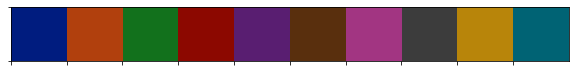

In [1]:
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import sklearn as skl
import requests
import re
from pandas import json_normalize
from validate_docbr import CNPJ

sns.set_palette('dark')
sns.palplot(sns.color_palette('dark'))

In [2]:
'Hoje é dia {}.'.format(dt.datetime.now().strftime('%d/%m/%Y'))

'Hoje é dia 04/05/2020.'

## Carregando e Tratando o DataFrame

O arquivo que será processado é referente ao IQR - Índice de Qualificação pelo Recebimento

In [3]:
dados = pd.read_excel('Qualificação de Fornecedores.xlsx')
dados.drop(columns = ['DENTRO DO EXPEDIENTE', 'ENTRE 11H E 13H', 'ACIMA DAS 16H - SEG/QUI', 'ACIMA DAS 15H - SEX', 'FIM DE SEMANA - SÁB/DOM', 'Último MOD009'])
filter1 = (dados['Situação'] != 'INATIVO')
periodo = dados[filter1]
dados.set_index(keys='CNPJ', inplace=True)
filter2 = dados['REC'] > 0
dados = dados[filter2]

In [19]:
print('O período avaliado corresponde de {} até {}.\nNeste cenário, estão sendo avaliados {} fornecedores ao todo.'.format((periodo['Última Entrada de NF'].min().strftime('%d/%m/%Y')),(periodo['Última Entrada de NF'].max().strftime('%d/%m/%Y')),(dados.shape[0])))

O período avaliado corresponde de 31/10/2019 até 30/04/2020.
Neste cenário, estão sendo avaliados 272 fornecedores ao todo.


* INATIVOS: São fornecedores cujo intervalo considerado não realizaram nenhum fornecimento, e por isso não estão sendo avaliados.

* Neste mesmo arquivo, também iremos precisar da planilha com os detalhamentos de cada ocorrência:

In [5]:
divergencias = pd.read_excel('Qualificação de Fornecedores.xlsx',sheet_name=1)
filter1 = (divergencias['Divergência'] != 0)
divergencias = divergencias[filter1]
filter2 = (divergencias['Contabiliza?'] == 'S')
divergencias = divergencias[filter2]

# Validando Cadastro de Fornecedor

## Visualizando os Dados

A composição desses dados considera, de um determinado período:
* A quantidade de relatórios gerados pelo Recebimento (salvos na pasta de <b>FollowUp</b>)
* Todas as ocorrências registradas pelo Recebimento (chamadas <b>CLR - Controle de Liberação de Recebimento</b>)
* Importação das entradas de notas fiscais, através da Pesquisa Relacional (<b>1161 - SUP - Recebimento</b>)

Todos esses dados estão compilados e tratados na planilha de Qualificação de Fornecedores.

In [11]:
dados.head()

,IQR,QI_F,QI_D,REC,DENTRO DO EXPEDIENTE,ENTRE 11H E 13H,ACIMA DAS 16H - SEG/QUI,ACIMA DAS 15H - SEX,FIM DE SEMANA - SÁB/DOM,DR_F,...,Data Cadastro,Último Fornecimento,Última Entrada de NF,Último Recebimento,Média Leadtime (Dias),Controle de Estoque,% do Total Investido na Família dos Itens,% do Total Investido na Carteira do Comprador,% do Total Investido em Fornecedores,Total Investido
CNPJ,,,,,,,,,,,,,,,,,,,,,
10899795000175,0.500000,1,0,1,1,0,0,0,0,1,...,2014-04-08,EMBALAGENS(EXCETO PAPELAO),2020-02-17,2020-02-17 08:13:00,11.0,S,0.002854,0.000011,0.000015,252.00
92534593000194,0.833333,3,0,3,1,1,1,0,0,1,...,2010-10-28,ACESSORIOS,2020-01-14,2020-01-14 17:57:00,10.0,S,0.067746,0.000133,0.000191,3140.00
15523441000145,0.800000,2,1,2,2,0,0,0,0,0,...,2020-02-07,ELETRICA/MANUTENCAO,2020-03-11,2020-03-11 15:23:00,3.0,N,0.082941,0.000177,0.000151,2479.97
7358761020194,0.923077,7,0,6,6,0,0,0,0,1,...,2019-11-04,AÇO  LIGA 1010/1020,2020-02-11,2020-02-11 14:38:00,1.0,S,0.533237,0.001029,0.001074,17704.69
1426453000147,0.818182,8,2,1,0,0,1,0,0,0,...,2005-01-11,MOLDES E ESTAMPOS,2020-02-14,2020-01-15 16:27:00,0.0,N,0.070243,0.000102,0.000087,1431.40


In [7]:
pd.crosstab(dados['Último Fornecimento'],
                            dados['Último Comprador'],
                            values = dados['Total Investido'],
                            aggfunc='sum').replace(np.nan, '')

Último Comprador,COMPRA DE DESPESAS,FERNANDA FERREIRA FLORIANO,IVAN JUNIOR,SANDRA CAMARGO RAINHA,WESLLEY ARAUJO DE SOUZA
Último Fornecimento,,,,,
ACESSORIOS,,27835.1,,18514.5,
ADESIVOS/PROD.QUIMICOS ESPUMA,,149679,,2102.15,
ASSENTO/ENCOSTO PLASTICO,,,,,55017.9
ATIVO FIXO,,,142998,,
AÇO  LIGA 1010/1020,,,,33202.3,
BARRAS DE ACO,,,,20647.4,
BASES COMPRADAS/BENEFICIADAS,,,,72003.8,
BORDAS,,269332,,,
CHAPAS E BOBINAS DE ACO,,,,724038,


## Iniciando Algumas Análises

### Dados Estatísticos sobre o Total Investido

In [8]:
dados.groupby(['Último Comprador'])['Total Investido'].describe().round(2)

,count,mean,std,min,25%,50%,75%,max
Último Comprador,,,,,,,,
COMPRA DE DESPESAS,3.0,71410.71,113463.33,552.94,5977.54,11402.14,106839.60,202277.06
FERNANDA FERREIRA FLORIANO,85.0,60095.30,136304.96,52.79,2633.76,9498.00,47977.54,924737.36
IVAN JUNIOR,100.0,4632.99,7878.27,0.00,726.54,1965.80,4914.62,44563.24
SANDRA CAMARGO RAINHA,78.0,40477.70,77364.39,80.00,2810.23,9033.48,36071.05,400603.14
WESLLEY ARAUJO DE SOUZA,6.0,22694.97,17371.33,8303.39,13006.94,15410.43,26219.02,55017.90


Totalizando os registros de fornecedores por situação:

In [9]:
sitacoes = pd.DataFrame(dados['Situação'].value_counts()).rename(columns={'Situação':'Qtde. Fornecedores'}).sort_values(by='Qtde. Fornecedores',ascending=False)
sitacoes['Qtde. Fornecedores (%)'] = dados['Situação'].value_counts(normalize=True).round(4)*100
sitacoes['Total Investido (R$)'] = dados.groupby(['Situação'])['Total Investido'].sum()
sitacoes['Total Investido (%)'] = ((dados.groupby(['Situação'])['Total Investido'].sum())/dados['Total Investido'].sum()).round(4)*100
sitacoes

,Qtde. Fornecedores,Qtde. Fornecedores (%),Total Investido (R$),Total Investido (%)
APROVADO,254,93.38,8291556.31,91.33
REPROVADO,11,4.04,281410.72,3.10
APROVADO COM RESTRIÇÃO,6,2.21,506095.90,5.57
INATIVO,1,0.37,0.00,0.00


### Avaliando a Dispersão entre a Quantidade de Itens Fornecidos e a Pontuação do IQR

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.scatterplot(dados['IQR'], dados['QI_F'])
ax.set_title('Dispersão entre o IQR e a quantidade de itens fornecidos', fontsize=20)

### Avaliando a Dispersão e Distribuição entre a Média de Leadtime (Dias) e a Quantidade de Itens Fornecidos

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.scatterplot(dados['Média Leadtime (Dias)'], dados['QI_F'])
ax.set_title('Dispersão entre o leadtime e a quantidade de itens fornecidos', fontsize=20)

In [ ]:
dados_lt = dados[['Cidade','UF','Média Leadtime (Dias)']]
filter = dados_lt['Média Leadtime (Dias)'] > 0
dados_lt = dados_lt[filter]
dados_lt.sort_values(by='Média Leadtime (Dias)',ascending=False)

In [ ]:
ax = plt.figure(figsize=(25, 25))
ax = sns.boxplot(x=dados_lt['Média Leadtime (Dias)'],y=dados_lt['UF'],width=0.6)
ax.set_title('Distribuição de frequência por leadtime, em dias, por UF', fontsize=20)

In [ ]:
dados_lt.groupby(['UF']).describe()

## Removendo Registros que Possuam Quantidade Inferior a 10 Itens Lançados pelo Fiscal

In [ ]:
filter = dados['QI_F'] > 10
dados1 = dados[filter]
dados1.head()

In [ ]:
print('Depois dessa limpeza, estão sendo analisados {} fornecedores. {} fornecedores foram removidos'.format((dados1.shape[0]),(dados.shape[0]-dados1.shape[0])))

In [ ]:
pd.crosstab(dados1['Último Fornecimento'],
                            dados1['Último Comprador'],
                            values = dados1['Total Investido'],
                            aggfunc='sum').replace(np.nan, '')

## Visualizando a Distribuição de Frequência de Quantidade de Itens Fornecidos conforme Situação

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.boxplot(x = dados1['QI_F'], y = dados1['Situação'])
ax.set_title('Qualificação por quantidade de itens fornecidos', fontsize=20)

## Avaliando IQR por Total Investido (DataFrame)

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.scatterplot(dados['IQR'], dados['Total Investido'])
ax.set_title('Dispersão do IQR por total investido', fontsize=20)

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.boxplot(x = dados['Total Investido'], y = dados['Situação'])
ax.set_title('Distribuição por Investimento', fontsize=20)

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.scatterplot(dados['QI_F'], dados['Total Investido'])
ax.set_title('Quantidade fornecida por valor investido', fontsize=20)

## Limpando os Outliers - Total Investido

In [ ]:
ax = plt.figure(figsize=(25, 7))
ax = mpimg.imread('Boxplot-04.png')
plt.axis('off')
plt.imshow(ax)

### Gravando as Variáveis
* <b>Q1</b> = Primeiro quartil do Total Investido (25% da distribuição)
* <b>Q3</b> = Terceiro quartil do Total Investido (75% da distribuição)
* <b>IQR</b> = Q3 - Q1

### Processando a Fórmula
* <b>Outlier Mínimo</b> = Q1 - 1.5*IQR
* <b>Outlier Máximo</b> = Q3 + 1.5*IQR

In [ ]:
# Gravando as Variáveis
Q1 = dados['Total Investido'].quantile(.25)
Q3 = dados['Total Investido'].quantile(.75)
IQR = Q3 - Q1

# Processando a Fórmula
outlier_min = Q1 - 1.5*IQR
outlier_max = Q3 + 1.5*IQR

# Aplicando no DataFrame
filter = (dados['Total Investido'] < outlier_max) & (dados['Total Investido'] > outlier_min)
df_sem_out = dados[filter]
df_sem_out.head()

In [ ]:
print('Depois dessa limpeza, estão sendo analisados {} fornecedores. {} fornecedores foram removidos'.format((df_sem_out.shape[0]),(dados.shape[0]-df_sem_out.shape[0])))

In [ ]:
pd.crosstab(df_sem_out['Último Fornecimento'],
                            df_sem_out['Último Comprador'],
                            values = df_sem_out['Total Investido'],
                            aggfunc='sum').replace(np.nan, '')

### Reprocessando e Visualizando os Dados

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.scatterplot(df_sem_out['QI_F'], df_sem_out['Total Investido'])
ax.set_title('Quantidade fornecida por valor investido', fontsize=20)

In [ ]:
df_sem_out[['Total Investido']].describe().round(2)

## Visualizando a Distribuição de Valor Investido por Situação

In [ ]:
ax = plt.figure(figsize=(25, 5))
ax = sns.boxplot(x = df_sem_out['Total Investido'], y = df_sem_out['Situação'])
ax.set_title('Qualificação Por Investimento', fontsize=20)

In [ ]:
filter = df_sem_out['Situação'] != 'APROVADO'
sem_aprovados = df_sem_out[filter]

print('Depois dessa limpeza, estão sendo analisados {} fornecedores. {} fornecedores foram removidos.'.format((sem_aprovados.shape[0]),(df_sem_out.shape[0]-sem_aprovados.shape[0])))

## Revelando os Principais Fornecedores que Merecem Atenção

In [ ]:
pd.DataFrame(sem_aprovados.groupby(['Situação','Último Fornecimento','Razão Social'])['Total Investido'].sum()).sort_values(by='Total Investido',ascending=False)

In [ ]:
sit_sem_aprovados = pd.DataFrame(sem_aprovados.groupby(['Situação'])['Total Investido'].sum()).sort_values(by='Total Investido',ascending=False)
sit_sem_aprovados['Total Investido (%)'] = (sit_sem_aprovados['Total Investido']/dados['Total Investido'].sum()).round(4)*100
sit_sem_aprovados

O valor total investido nestes fornecedores, considerando o período avaliado por comprador, se resumem em (R$):

In [ ]:
pd.crosstab(sem_aprovados['Último Comprador'],
                           sem_aprovados['Situação'],
                           values = sem_aprovados['Total Investido'],
                           aggfunc='sum').replace(np.nan, 0).sort_values(by='REPROVADO',ascending=False)

In [ ]:
pd.crosstab(sem_aprovados['Razão Social'],
                            sem_aprovados['Último Comprador'],
                            values = sem_aprovados['Total Investido'],
                            aggfunc='sum').replace(np.nan, '')

## Contabilização de Divergências no Recebimento, cuja Responsabilidade foi da Alberflex

In [ ]:
erros_alberflex = pd.DataFrame(dados.groupby(['Último Comprador'])['DR_A'].sum())
filter = erros_alberflex['DR_A'] > 0
erros_alberflex = erros_alberflex[filter]
erros_alberflex['DR_A (%)'] = (erros_alberflex['DR_A']/erros_alberflex['DR_A'].sum()).round(4)*100
erros_alberflex.sort_values(by='DR_A',ascending=False)

## Contabilização de Divergências no Recebimento, cuja Responsabilidade foi do Fornecedor

In [ ]:
erros_fornecedor = pd.DataFrame(dados.groupby(['Último Fornecimento','Razão Social'])['DR_F'].sum())
filter = erros_fornecedor['DR_F'] > 0
erros_fornecedor = erros_fornecedor[filter]
erros_fornecedor['DR_F (%)'] = (erros_fornecedor['DR_F']/erros_fornecedor['DR_F'].sum()).round(4)*100
erros_fornecedor.sort_values(by='DR_F',ascending=False).head()

In [ ]:
filter = (df['DR_F'] != 0) | (df['DR_A'] != 0)
df_diverg = df[filter]
df_diverg.head()

### Filtrando Apenas pelas Ocorrências Computadas no Período

In [ ]:
filter = (divergencias['Contabiliza?'] == 'S')
div_contabiliza = divergencias[filter]
div_contabiliza.set_index(keys='CNPJ', inplace=True)
div_contabiliza.head()

In [ ]:
div_stats = pd.DataFrame(div_contabiliza['Divergência'].value_counts()).rename(columns={'Divergência':'Qtde. Ocorrências'}).sort_values(by='Qtde. Ocorrências',ascending=False)
div_stats['Percentual de Ocorrências (%)'] = div_contabiliza['Divergência'].value_counts(normalize=True).round(4)*100
div_stats

In [ ]:
div_contabiliza.shape[0]

In [ ]:
respons_pct = pd.crosstab(div_contabiliza['Fornecedor'],
                        div_contabiliza['Divergência'],
                        values = div_contabiliza['Responsável'],
                        aggfunc='count',
                        normalize=True).replace((np.nan), '').round(4)*100
respons_pct

In [ ]:
respons_qtd = pd.crosstab(div_contabiliza['Divergência'],
                        div_contabiliza['Responsável'],
                        values = div_contabiliza['Responsável'],
                        aggfunc='count').replace(np.nan, '')
respons_qtd

In [ ]:
forn_qtd = pd.crosstab(div_contabiliza['Fornecedor'],
                        div_contabiliza['Responsável'],
                        values = div_contabiliza['Responsável'],
                        aggfunc='count').replace(np.nan, '')
forn_qtd

In [ ]:
forn_pct = pd.crosstab(div_contabiliza['Fornecedor'],
                       div_contabiliza['Responsável'],
                       values = div_contabiliza['Responsável'],
                       aggfunc='count',
                       normalize=True).replace(np.nan, '').round(4)*100
forn_pct